In [3]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GB, 
    GradientBoostingClassifier as GC)
from ISLP.bart import BART
import sklearn.model_selection as skm
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import networkx as nx
import graphviz
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Read the data

In [4]:
data = pd.read_pickle("data.pkl")

# PS MODEL

ATE estimation

In [5]:
covariates = ["ba_quality", "language_skills", 
              "exp_highquality", "ma", "certificate",
              'occ_Administrative', 'occ_Biotech and Pharmacy', 'occ_Civil Engineer',
              'occ_Clerical', 'occ_Ecommerce', 'occ_Education',
              'occ_Electrical Engineer', 'occ_Executive Assistant', 'occ_Finance',
              'occ_Food Services Managers', 'occ_Human Resources Payroll',
              'occ_Insurance', 'occ_Maintenance Technician',
              'occ_Marketing and Sales', 'occ_Media and Arts', 'occ_Production',
              'occ_Programmer', 'occ_Retail', 'occ_Social Worker', 'occ_Technology']

treatments = ["female_type1", "female_type2", "female_type3", "female_type4"]

for tvar in treatments:
    W = data[tvar]
    ps_model = LogisticRegression(solver='liblinear')
    ps_model.fit(data[covariates], W)
    
    # Predicted PS
    data[f"ps_{tvar}"] = ps_model.predict_proba(data[covariates])[:,1]

    # We clip the propensity scores to avoid estimation problems
    data[f"ps_{tvar}"] = data[f"ps_{tvar}"].clip(lower=0.05, upper=0.95)
    
    # Bin the PS
    thresholds = np.linspace(0, 1, 6)
    data['ps_bin'] = pd.cut(data[f"ps_{tvar}"], bins=thresholds, labels=False, include_lowest=True)

In [6]:
# Function: stratified ATE for a given treatment variable
def stratified_ate(df, treatment_var):
    bin_diffs = []
    bin_sizes = []
    for b in df['ps_bin'].unique():
        bin_df = df[df['ps_bin'] == b]
        treated_mean = bin_df[bin_df[treatment_var] == 1]['callback'].mean()
        control_mean = bin_df[bin_df[treatment_var] == 0]['callback'].mean()
        
        if not np.isnan(treated_mean) and not np.isnan(control_mean):
            bin_diffs.append(treated_mean - control_mean)
            bin_sizes.append(len(bin_df))
    
    if len(bin_diffs) == 0:
        return np.nan
    
    return np.average(bin_diffs, weights=bin_sizes)

# List of 4 interaction treatment variables
treatments = ["female_type1", "female_type2", "female_type3", "female_type4"]

# Storage for results
ate_results = {}
ci_results = {}
boot_ates_dict = {}

# Loop over treatments
for tvar in treatments:
    print(f"\nProcessing {tvar} ...")
    
    # Compute original ATE
    ate_original = stratified_ate(data, tvar)
    ate_results[tvar] = ate_original
    
    # Bootstrap
    n_bootstrap = 1000
    boot_ates = []
    
    for i in range(n_bootstrap):
        boot_sample = data.sample(frac=1, replace=True)
        boot_ate = stratified_ate(boot_sample, tvar)
        if not np.isnan(boot_ate):
            boot_ates.append(boot_ate)

    # Store the bootstrap ATEs 
    boot_ates_dict[tvar] = boot_ates
    
    # 95% CI
    ci_lower = np.percentile(boot_ates, 2.5)
    ci_upper = np.percentile(boot_ates, 97.5)
    ci_results[tvar] = (ci_lower, ci_upper)

# Print results
print("ATE and 95% bootstrap CIs:")
for t in treatments:
    l, u = ci_results[t]
    print(f"{t}: ATE = {ate_results[t]:.4f}, CI = [{l:.4f}, {u:.4f}]")



Processing female_type1 ...


KeyboardInterrupt: 

In [29]:
# Empty dataframe
table = pd.DataFrame(index=treatments, columns=["ATE (SE)"])

for tvar in treatments:
    # Point estimate from bootstrap mean
    ate = np.mean(boot_ates_dict[tvar])
    
    # Standard error from bootstrap
    se = np.std(boot_ates_dict[tvar], ddof=1)
    
    # Store in table
    table.loc[tvar, "ATE (SE)"] = f"{ate:.4f} ({se:.4f})"

# Display table
print("\nATEs with bootstrap standard errors:")
print(table)

# Export to LATEX
print(table.to_latex())


ATEs with bootstrap standard errors:
                      ATE (SE)
female_type1   0.0087 (0.0079)
female_type2   0.0024 (0.0093)
female_type3  -0.0188 (0.0093)
female_type4  -0.0397 (0.0083)
\begin{tabular}{ll}
\toprule
 & ATE (SE) \\
\midrule
female_type1 & 0.0087 (0.0079) \\
female_type2 & 0.0024 (0.0093) \\
female_type3 & -0.0188 (0.0093) \\
female_type4 & -0.0397 (0.0083) \\
\bottomrule
\end{tabular}



# POSITIVITY PLOT

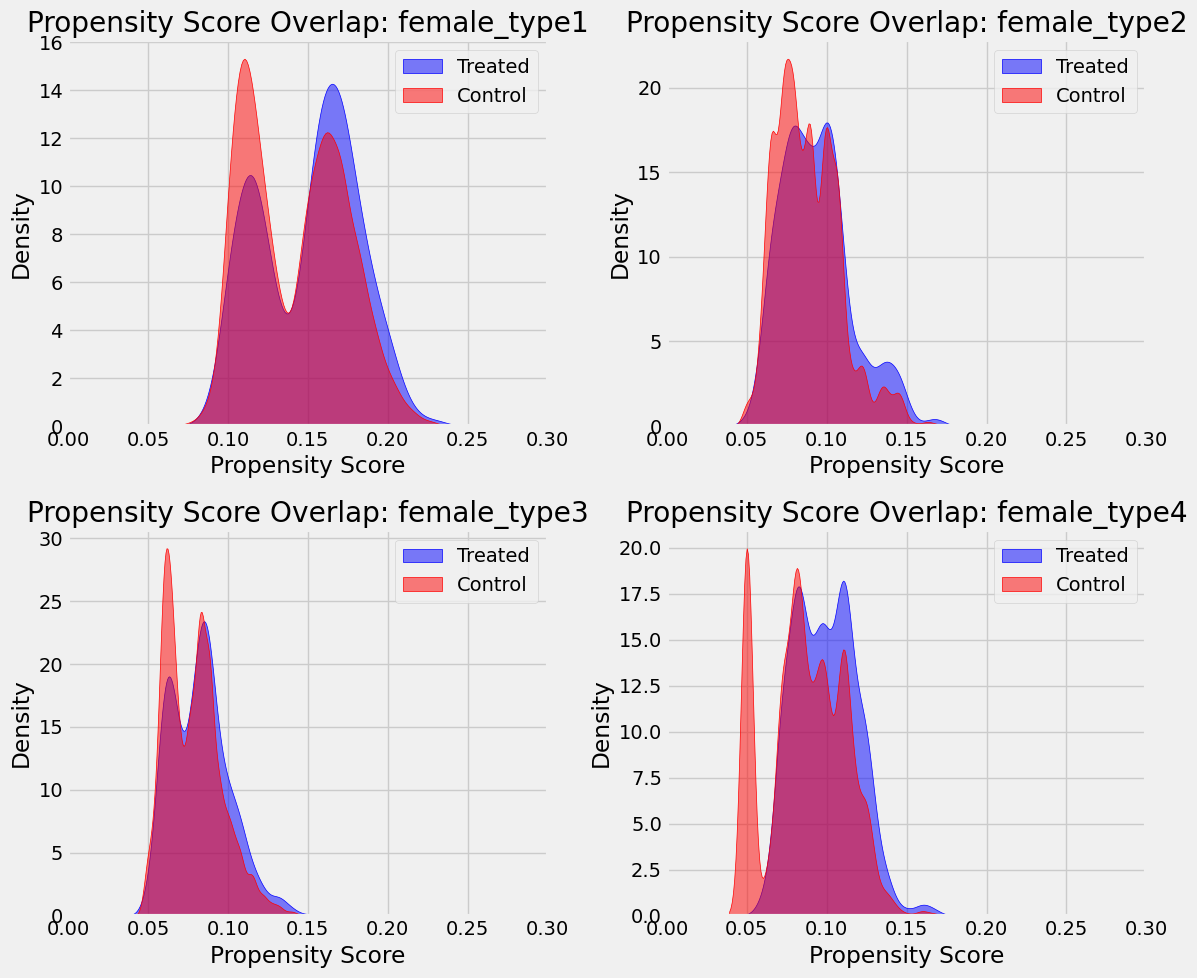

In [7]:
ps_cols = ["ps_female_type1", "ps_female_type2", "ps_female_type3", "ps_female_type4"]
treatments = ["female_type1", "female_type2", "female_type3", "female_type4"]

# Plot settings
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()

# Loop plots across treatments
for i, tvar in enumerate(treatments):
    ps_col = ps_cols[i]
    sns.kdeplot(data=data[data[tvar]==1], x=ps_col, fill=True, label='Treated', ax=axes[i], color='blue', alpha=0.5)
    sns.kdeplot(data=data[data[tvar]==0], x=ps_col, fill=True, label='Control', ax=axes[i], color='red', alpha=0.5)
    axes[i].set_title(f"Propensity Score Overlap: {tvar}")
    axes[i].set_xlabel("Propensity Score")
    axes[i].set_ylabel("Density")
    axes[i].set_xlim(0,0.3)
    axes[i].legend()

# Print plot
plt.tight_layout()
plt.savefig(f"positivity{i}.jpg", dpi=300, bbox_inches='tight')
plt.show()


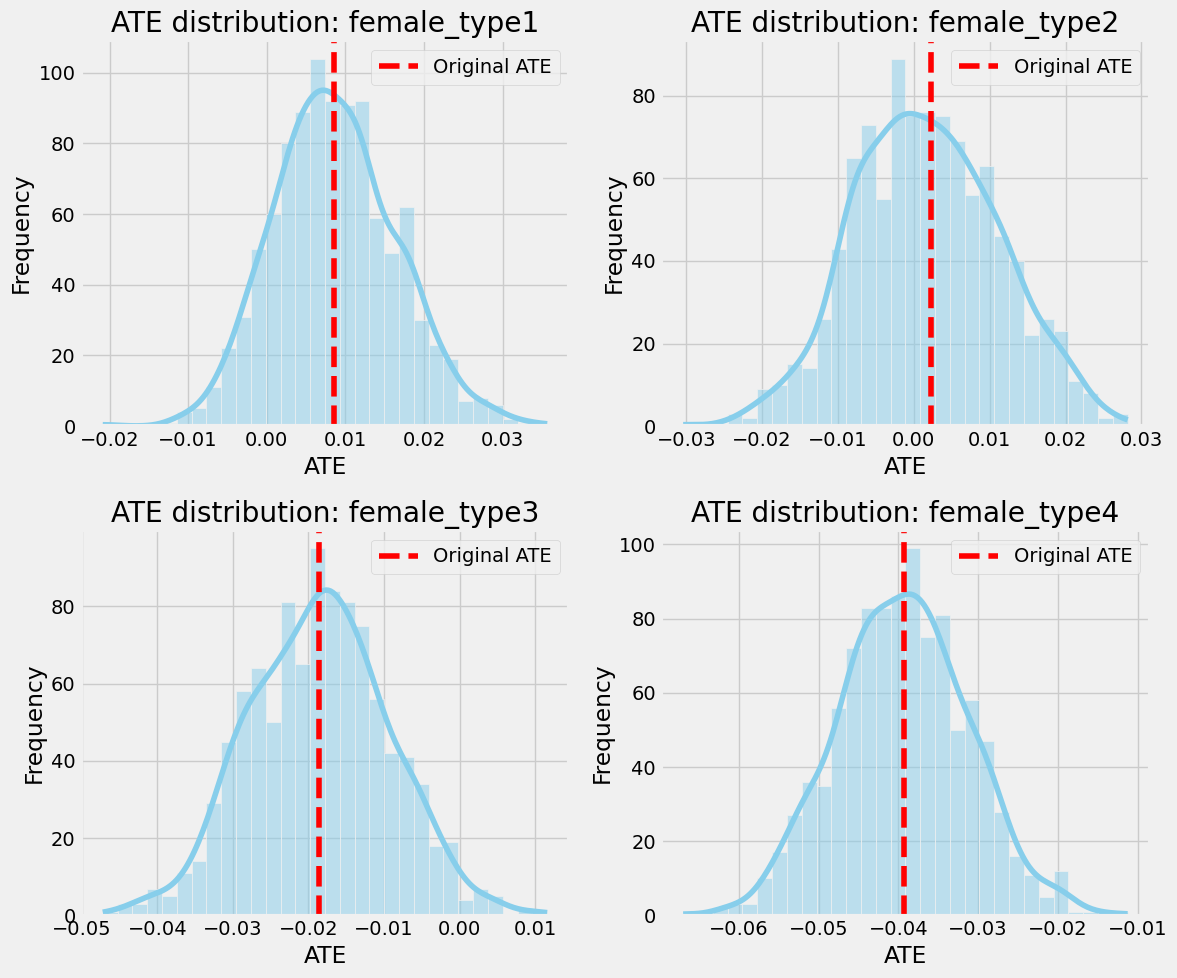

In [12]:
# Plot settings
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Loop plots across treatments
for i, tvar in enumerate(treatments):
    sns.histplot(boot_ates_dict[tvar], bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].axvline(ate_results[tvar], color='red', linestyle='--', label='Original ATE')
    axes[i].set_title(f"ATE distribution: {tvar}")
    axes[i].set_xlabel("ATE")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

# Print plots
plt.tight_layout()
plt.savefig(f"PS_ate_dist_{i}.jpg", dpi=300, bbox_inches='tight')
plt.show()